# Time Series Forcasting Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from datetime import timedelta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/processed_train.csv", parse_dates=["Date"])


In [ ]:
# use only open days
train = train[train["Open"]==1]
train = train.sort_values("Date")
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Year,Month,Day,Weekday,IsWeekend,MonthPart,IsHoliday,DaysBeforeHoliday,DaysAfterHoliday,CompetitionOpenMonths
844391,1097,2,2013-01-01,5961,1405,1,0,1.0,1,b,...,2013,1,1,1,0,Start,1,0.0,0.0,130.0
844375,85,2,2013-01-01,4220,619,1,0,1.0,1,b,...,2013,1,1,1,0,Start,1,0.0,0.0,15.0
844376,259,2,2013-01-01,6851,1444,1,0,1.0,1,b,...,2013,1,1,1,0,Start,1,0.0,0.0,0.0
844377,262,2,2013-01-01,17267,2875,1,0,1.0,1,b,...,2013,1,1,1,0,Start,1,0.0,0.0,0.0
844378,274,2,2013-01-01,3102,729,1,0,1.0,1,b,...,2013,1,1,1,0,Start,1,0.0,0.0,0.0


In [ ]:
# Daily total sales
ts = train.groupby("Date")["Sales"].sum().asfreq("D").fillna(0)             # Top store
ts.head()

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593


#### We analyze a single high-activity store to reduce noise and understand time patterns clearly.

In [ ]:
# Last Available Date
last_date = ts.index.max()
print("Last available date:", last_date)

Last available date: 2015-07-31 00:00:00


### Visualize Time Series

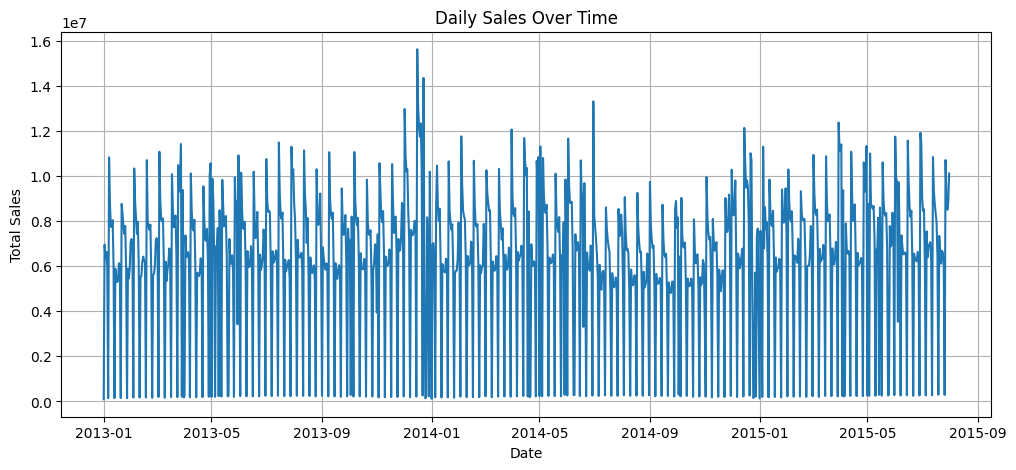

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(ts)
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


### Rolling Mean & Std (Trend Check)

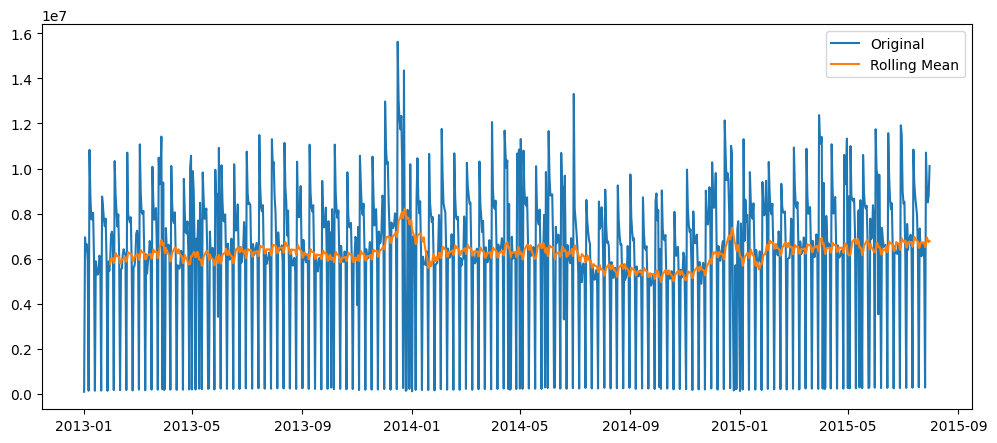

In [ ]:
roll_mean = ts.rolling(30).mean()
roll_std = ts.rolling(30).std()

plt.figure(figsize=(12,5))
plt.plot(ts,label="Original")
plt.plot(roll_mean,label="Rolling Mean")
plt.legend()
plt.show()


### Stationarity Check
#### ADF Test

In [ ]:
adf_result = adfuller(ts)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -4.761614524595615
p-value: 6.436731330559343e-05


#### p-value > 0.05 = non-stationary means differencing required.

#### Differencing

ADF after differencing: 3.7500440046048496e-26


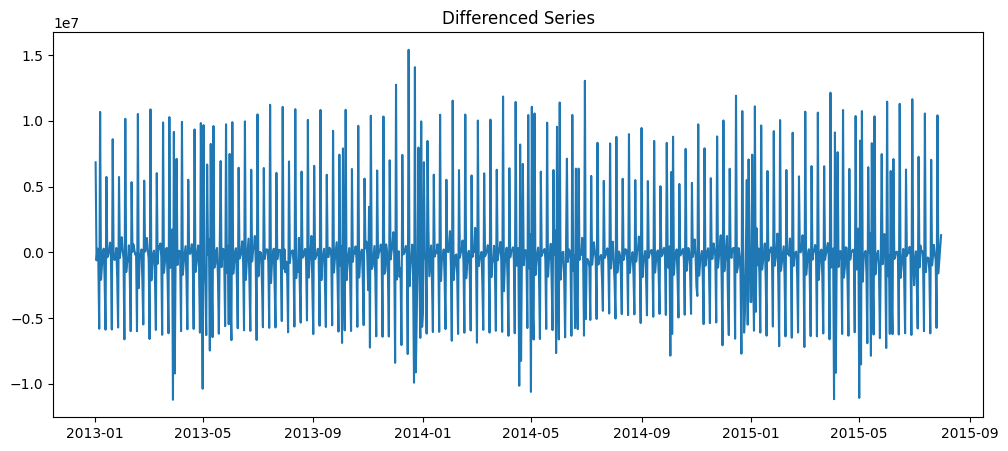

In [ ]:
ts_diff = ts.diff().dropna()

result = adfuller(ts_diff)

print("ADF after differencing:", result[1])

plt.figure(figsize=(12,5))
plt.plot(ts_diff)
plt.title("Differenced Series")
plt.show()


### Seasonal Aanlysis
#### Decomposition

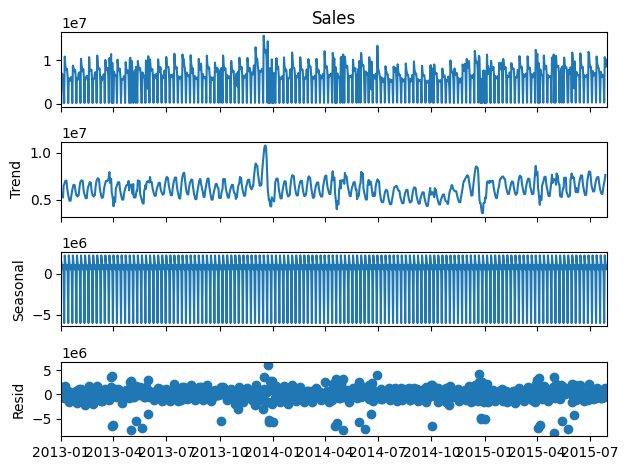

In [ ]:
decomp = seasonal_decompose(ts, model="additive", period=7)
decomp.plot()
plt.show()


#### Interpretation:

#### Trend shows long-term movement

#### Seasonality shows weekly pattern

#### Residual shows randomness

#### ACF & PACF (Justifying ARIMA)

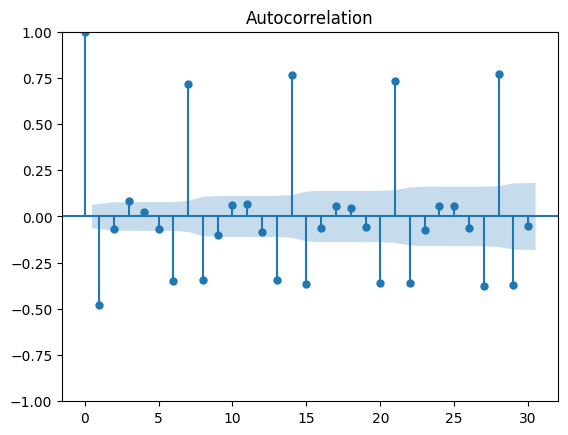

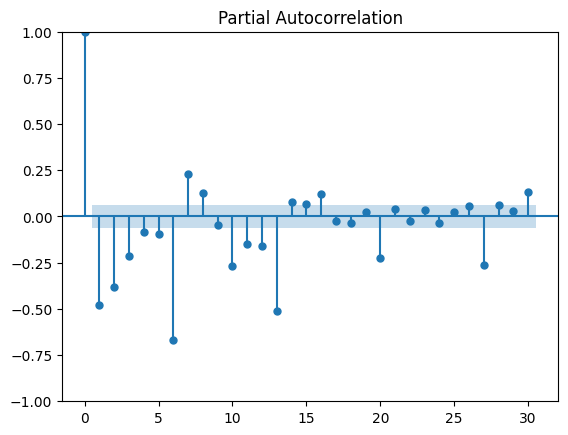

In [ ]:
plot_acf(ts_diff, lags=30)
plt.show()

plot_pacf(ts_diff, lags=30)
plt.show()


#### ACF suggests MA terms.
#### PACF suggests AR terms.
#### Hence ARIMA(p,d,q) choice is guided by plots.

### MODELING

### Train/Validation Split

In [ ]:
forecast_horizon = 42

train = ts[:-forecast_horizon]
test = ts[-forecast_horizon:]


### Naive Baseline

In [ ]:
naive_forecast = test.shift(1)

rmse_naive = np.sqrt(
    mean_squared_error(test[1:], naive_forecast[1:])
)

print("Naive RMSE:", rmse_naive)


Naive RMSE: 4254837.911359162


### Train ARIMA Model

In [ ]:
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()

model_fit.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  900
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -14714.790
Date:                Sun, 15 Feb 2026   AIC                          29439.580
Time:                        07:55:57   BIC                          29463.586
Sample:                    01-01-2013   HQIC                         29448.751
                         - 06-19-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8825      0.063    -14.091      0.000      -1.005      -0.760
ar.L2         -0.1254      0.037     -3.354      0.001      -0.199      -0.052
ma.L1         -0.1019      0.050     -2.046      0.041      -0.200      -0.004
ma.L2         -0.8825      0.049    -17.898      0.000      -0.979      -0.786
sigma2      1.131e+13   5.25e-16   2.15e+28      0.000    1.13e+13    1.13e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                42.52
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.53
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.95e+45. Standard errors may be unstable.
"""

### Forecast on Test

In [ ]:
forecast = model_fit.forecast(steps=forecast_horizon)
forecast = pd.Series(forecast, index=test.index)

forecast.head()

,predicted_mean
Date,
2015-06-20,7.245459e+06
2015-06-21,5.419457e+06
2015-06-22,7.182941e+06
2015-06-23,5.855607e+06
2015-06-24,6.805880e+06


#### Metrics (Evaluation)

In [ ]:
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)

print("ARIMA RMSE:", rmse)
print("ARIMA MAPE:", mape)


ARIMA RMSE: 3017151.9788554837
ARIMA MAPE: 3.2676821408376666


### Plot Forecast vs Actual

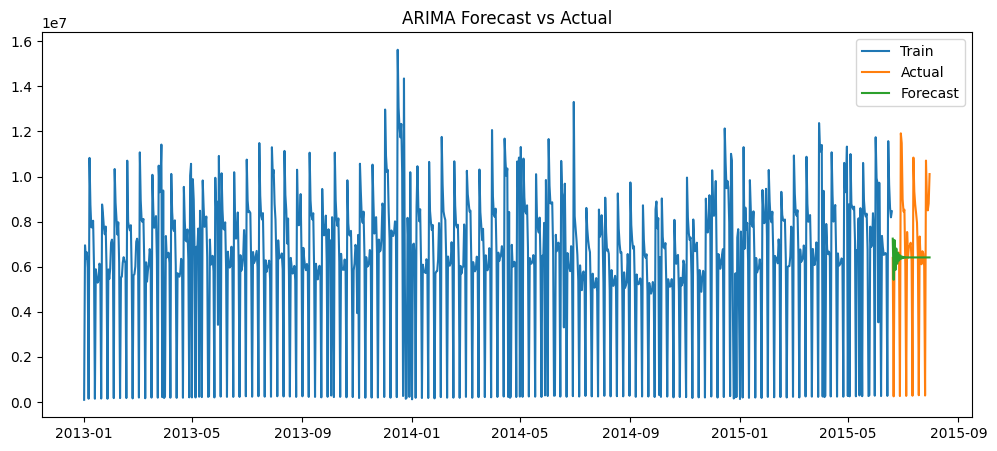

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Forecast")

plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


## Conclusion:

#### Sales show strong weekly seasonality.

#### Series was non-stationary; differencing fixed it.

#### ARIMA performed better than naive baseline.

#### Model captures trend but struggles with sudden spikes.

#### This justifies moving to ML/LSTM for better performance

### MODEL FOR FUTURE FORECAST

In [ ]:
# Retrain on Full Data
final_model = ARIMA(ts, order=(2,1,2)).fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Plot Forecast

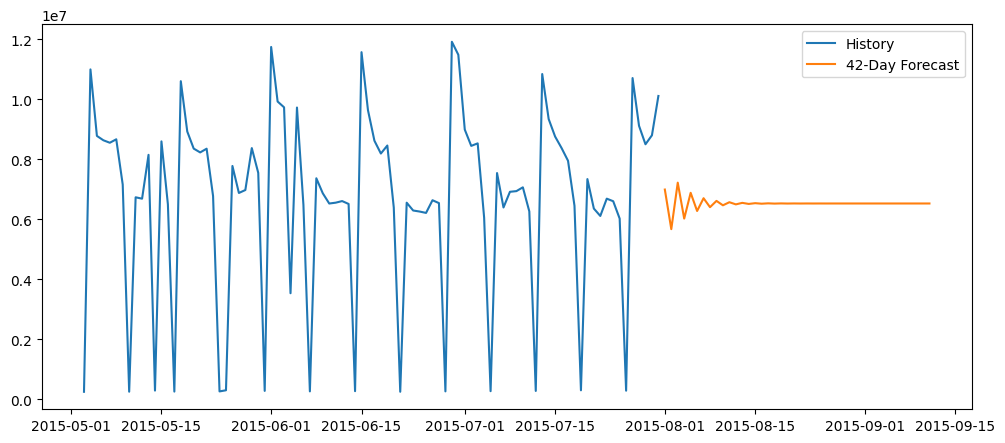

In [ ]:
future = final_model.forecast(42)

plt.figure(figsize=(12,5))
plt.plot(ts[-90:],label="History")
plt.plot(future,label="42-Day Forecast")

plt.legend()
plt.show()


### 6 weeks Future Forecast

In [ ]:
future_forecast = final_model.forecast(42)

future_forecast.head()


,predicted_mean
2015-08-01,6.990767e+06
2015-08-02,5.670762e+06
2015-08-03,7.219810e+06
2015-08-04,6.022750e+06
2015-08-05,6.881866e+06


### Save Forecast

In [ ]:
future_forecast.to_csv(
    "/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/arima_42day_future_forecast.csv"
)